In this notebook, we will build a 3D map of a scene from a small set of images and refine it with the featuremetric optimization. We then localize an image downloaded from the Internet and show the effect of the refinement.

# Setup
We start by defining some output paths: where the intermediate files will be stored.

In [54]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
import os
import time
import sys
from hloc import extract_features, match_features, reconstruction, pairs_from_exhaustive, visualization
from hloc.visualization import plot_images, read_image
from hloc.utils.viz_3d import init_figure, plot_points, plot_reconstruction, plot_camera_colmap
from pixsfm.util.visualize import init_image, plot_points2D
from pixsfm.refine_hloc import PixSfM
from pixsfm import ostream_redirect
from PIL import Image, ImageDraw
import pycolmap
from pathlib import Path
#import visualize_model
# redirect the C++ outputs to notebook cells
cpp_out = ostream_redirect(stderr=True, stdout=True)
cpp_out.__enter__()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
import torch 
print(torch.__version__)
print(torch.cuda.get_arch_list())

1.9.1+cu111
['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']


In [56]:
#svo file used: front_2023-11-03-10-51-17.svo 

In [57]:
'''
Generates input data for the pixSFM pipeline 
by processing the output of the svo pipeline
'''

import os
import shutil

# Define the source directory and the target directory
src_dir = '../svo_output'
dst_dir = '../pixsfm_dataset'

!rm -rf $dst_dir

# Create 'left' and 'right' directories inside 'dataset'
os.makedirs(os.path.join(dst_dir, 'left'), exist_ok=True)
os.makedirs(os.path.join(dst_dir, 'right'), exist_ok=True)

# Iterate over all directories in the source directory
for dir_name in os.listdir(src_dir):
    frame_dir = os.path.join(src_dir, dir_name)
    if os.path.isdir(frame_dir):
        images_dir = os.path.join(frame_dir, 'images')
        if os.path.isdir(images_dir):
            # Copy 'left.jpg' to 'dataset/left' and 'right.jpg' to 'dataset/right'
            for file_name in os.listdir(images_dir):
                if file_name == 'left_image.jpg':
                    shutil.copy(os.path.join(images_dir, file_name), os.path.join(dst_dir, 'left', dir_name + '_.jpg'))
                elif file_name == 'right_image.jpg':
                    shutil.copy(os.path.join(images_dir, file_name), os.path.join(dst_dir, 'right', dir_name + '_.jpg'))

In [58]:
images = Path('../pixsfm_dataset/')
outputs = Path('../pixsfm_outputs/')
!rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'
raw_dir = outputs / "raw"
ref_dir_locked = outputs / "ref_locked"

In [59]:
os.listdir(images)

['left', 'right']

Here we will use SuperPoint local features with the SuperGlue matcher, but it's easy to switch to other features like SIFT or R2D2.

In [60]:
feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

# 3D mapping and refinement
First we list the images used for mapping. These are all day-time shots of Sacre Coeur.

In [61]:
# '''masking of the tractor hood from the images '''
# ''' output => datasets/monarch/{target_folder}/image_name.jpg '''
# def draw_box_around_tractor_hood(image_path, target_folder): 
#     image = Image.open(image_path)
#     w, h = image.size
#     box_x1, box_y1 = 460, 770  # Top-left corner
#     box_x2, box_y2 = 1630, 1080  # Bottom-right corner
#     outline_color = (0, 0, 0)  # Red in RGB format
#     fill_color = (0, 0, 0)  # Black in RGB format
#     draw = ImageDraw.Draw(image)
#     draw.rectangle([box_x1, box_y1, box_x2, box_y2], outline=outline_color, fill=fill_color)
#     directory_path,filename = os.path.split(image_path)
#     parent_directory_path = os.path.dirname(directory_path)
#     target_directory = os.path.join(parent_directory_path, target_folder)
#     os.makedirs(target_directory, exist_ok = True)
#     target_image_path = os.path.join(target_directory,filename)
#     image.save(target_image_path)
#     return target_image_path 

In [62]:
os.listdir(images / 'left')

['frame_17_.jpg',
 'frame_10_.jpg',
 'frame_9_.jpg',
 'frame_30_.jpg',
 'frame_3_.jpg',
 'frame_37_.jpg',
 'frame_34_.jpg',
 'frame_21_.jpg',
 'frame_11_.jpg',
 'frame_25_.jpg',
 'frame_27_.jpg',
 'frame_26_.jpg',
 'frame_33_.jpg',
 'frame_15_.jpg',
 'frame_2_.jpg',
 'frame_23_.jpg',
 'frame_13_.jpg',
 'frame_18_.jpg',
 'frame_0_.jpg',
 'frame_19_.jpg',
 'frame_22_.jpg',
 'frame_32_.jpg',
 'frame_29_.jpg',
 'frame_31_.jpg',
 'frame_14_.jpg',
 'frame_1_.jpg',
 'frame_6_.jpg',
 'frame_24_.jpg',
 'frame_7_.jpg',
 'frame_20_.jpg',
 'frame_39_.jpg',
 'frame_8_.jpg',
 'frame_35_.jpg',
 'frame_16_.jpg',
 'frame_28_.jpg',
 'frame_12_.jpg',
 'frame_36_.jpg',
 'frame_5_.jpg',
 'frame_4_.jpg',
 'frame_38_.jpg']

In [63]:
references_left = [str(p.relative_to(images)) for i, p in enumerate((images / 'left/').iterdir())]
references_right = [str(p.relative_to(images)) for i, p in enumerate((images / 'right/').iterdir())]

In [64]:
print(len(references_left))

40


In [65]:
a = references_left[0]
print(a.split("/")[-1].split("_"))

['frame', '17', '.jpg']


In [66]:
print(f"references_left: {references_left}")

references_left: ['left/frame_17_.jpg', 'left/frame_10_.jpg', 'left/frame_9_.jpg', 'left/frame_30_.jpg', 'left/frame_3_.jpg', 'left/frame_37_.jpg', 'left/frame_34_.jpg', 'left/frame_21_.jpg', 'left/frame_11_.jpg', 'left/frame_25_.jpg', 'left/frame_27_.jpg', 'left/frame_26_.jpg', 'left/frame_33_.jpg', 'left/frame_15_.jpg', 'left/frame_2_.jpg', 'left/frame_23_.jpg', 'left/frame_13_.jpg', 'left/frame_18_.jpg', 'left/frame_0_.jpg', 'left/frame_19_.jpg', 'left/frame_22_.jpg', 'left/frame_32_.jpg', 'left/frame_29_.jpg', 'left/frame_31_.jpg', 'left/frame_14_.jpg', 'left/frame_1_.jpg', 'left/frame_6_.jpg', 'left/frame_24_.jpg', 'left/frame_7_.jpg', 'left/frame_20_.jpg', 'left/frame_39_.jpg', 'left/frame_8_.jpg', 'left/frame_35_.jpg', 'left/frame_16_.jpg', 'left/frame_28_.jpg', 'left/frame_12_.jpg', 'left/frame_36_.jpg', 'left/frame_5_.jpg', 'left/frame_4_.jpg', 'left/frame_38_.jpg']


In [67]:
references_left = sorted(references_left, key=lambda x: int(x.split('/')[-1].split('_')[1]))
references_right = sorted(references_right, key=lambda x: int(x.split('/')[-1].split('_')[1]))

In [68]:
print(references_left)

['left/frame_0_.jpg', 'left/frame_1_.jpg', 'left/frame_2_.jpg', 'left/frame_3_.jpg', 'left/frame_4_.jpg', 'left/frame_5_.jpg', 'left/frame_6_.jpg', 'left/frame_7_.jpg', 'left/frame_8_.jpg', 'left/frame_9_.jpg', 'left/frame_10_.jpg', 'left/frame_11_.jpg', 'left/frame_12_.jpg', 'left/frame_13_.jpg', 'left/frame_14_.jpg', 'left/frame_15_.jpg', 'left/frame_16_.jpg', 'left/frame_17_.jpg', 'left/frame_18_.jpg', 'left/frame_19_.jpg', 'left/frame_20_.jpg', 'left/frame_21_.jpg', 'left/frame_22_.jpg', 'left/frame_23_.jpg', 'left/frame_24_.jpg', 'left/frame_25_.jpg', 'left/frame_26_.jpg', 'left/frame_27_.jpg', 'left/frame_28_.jpg', 'left/frame_29_.jpg', 'left/frame_30_.jpg', 'left/frame_31_.jpg', 'left/frame_32_.jpg', 'left/frame_33_.jpg', 'left/frame_34_.jpg', 'left/frame_35_.jpg', 'left/frame_36_.jpg', 'left/frame_37_.jpg', 'left/frame_38_.jpg', 'left/frame_39_.jpg']


In [69]:
print(len(references_left))

40


In [70]:
#references_left = references_left[40:82] 
#references_right = references_right[40:82]
references = references_left + references_right

In [71]:
print(f"references: {references}")

references: ['left/frame_0_.jpg', 'left/frame_1_.jpg', 'left/frame_2_.jpg', 'left/frame_3_.jpg', 'left/frame_4_.jpg', 'left/frame_5_.jpg', 'left/frame_6_.jpg', 'left/frame_7_.jpg', 'left/frame_8_.jpg', 'left/frame_9_.jpg', 'left/frame_10_.jpg', 'left/frame_11_.jpg', 'left/frame_12_.jpg', 'left/frame_13_.jpg', 'left/frame_14_.jpg', 'left/frame_15_.jpg', 'left/frame_16_.jpg', 'left/frame_17_.jpg', 'left/frame_18_.jpg', 'left/frame_19_.jpg', 'left/frame_20_.jpg', 'left/frame_21_.jpg', 'left/frame_22_.jpg', 'left/frame_23_.jpg', 'left/frame_24_.jpg', 'left/frame_25_.jpg', 'left/frame_26_.jpg', 'left/frame_27_.jpg', 'left/frame_28_.jpg', 'left/frame_29_.jpg', 'left/frame_30_.jpg', 'left/frame_31_.jpg', 'left/frame_32_.jpg', 'left/frame_33_.jpg', 'left/frame_34_.jpg', 'left/frame_35_.jpg', 'left/frame_36_.jpg', 'left/frame_37_.jpg', 'left/frame_38_.jpg', 'left/frame_39_.jpg', 'right/frame_0_.jpg', 'right/frame_1_.jpg', 'right/frame_2_.jpg', 'right/frame_3_.jpg', 'right/frame_4_.jpg', 'right/

In [72]:
'''sorting references so that each stereo pair is together in the list '''
references = sorted(references, key=lambda x: int(x.split('/')[-1].split('_')[1]))

In [73]:
print(references)

['left/frame_0_.jpg', 'right/frame_0_.jpg', 'left/frame_1_.jpg', 'right/frame_1_.jpg', 'left/frame_2_.jpg', 'right/frame_2_.jpg', 'left/frame_3_.jpg', 'right/frame_3_.jpg', 'left/frame_4_.jpg', 'right/frame_4_.jpg', 'left/frame_5_.jpg', 'right/frame_5_.jpg', 'left/frame_6_.jpg', 'right/frame_6_.jpg', 'left/frame_7_.jpg', 'right/frame_7_.jpg', 'left/frame_8_.jpg', 'right/frame_8_.jpg', 'left/frame_9_.jpg', 'right/frame_9_.jpg', 'left/frame_10_.jpg', 'right/frame_10_.jpg', 'left/frame_11_.jpg', 'right/frame_11_.jpg', 'left/frame_12_.jpg', 'right/frame_12_.jpg', 'left/frame_13_.jpg', 'right/frame_13_.jpg', 'left/frame_14_.jpg', 'right/frame_14_.jpg', 'left/frame_15_.jpg', 'right/frame_15_.jpg', 'left/frame_16_.jpg', 'right/frame_16_.jpg', 'left/frame_17_.jpg', 'right/frame_17_.jpg', 'left/frame_18_.jpg', 'right/frame_18_.jpg', 'left/frame_19_.jpg', 'right/frame_19_.jpg', 'left/frame_20_.jpg', 'right/frame_20_.jpg', 'left/frame_21_.jpg', 'right/frame_21_.jpg', 'left/frame_22_.jpg', 'right/

In [74]:
# ''' masking the tractor hood in all the images'''
# ''' returns list of path to the masked images '''
# start_time = time.time()
# target_folder = "masked_images"
# masked_references = [draw_box_around_tractor_hood(p, target_folder) for p in references]
# end_time = time.time()
# elapsed_time = end_time - start_time

# target_path = os.path.join(images, target_folder)

# ''' sorting masked_references sequentially '''
# ''' smf => sorted masked references '''
# #smf = sorted(masked_references, key = lambda x: int(((x.split("/")[-1]).split(".")[0]).split("_")[0]))

# print(f"type(masked_references): {type(masked_references)}")


In [75]:
# smf = []
# for i in range(0, len(references)//2 - 1): 
#     left  = "masked_images/" + str(i) + "_left.jpg"
#     right = "masked_images/" + str(i) + "_right.jpg"
#     smf.append(left)
#     smf.append(right)

In [76]:
# print(f"smf: {smf}")
# print(f"len(smf) : {len(smf)}")

In [77]:
print(references)

['left/frame_0_.jpg', 'right/frame_0_.jpg', 'left/frame_1_.jpg', 'right/frame_1_.jpg', 'left/frame_2_.jpg', 'right/frame_2_.jpg', 'left/frame_3_.jpg', 'right/frame_3_.jpg', 'left/frame_4_.jpg', 'right/frame_4_.jpg', 'left/frame_5_.jpg', 'right/frame_5_.jpg', 'left/frame_6_.jpg', 'right/frame_6_.jpg', 'left/frame_7_.jpg', 'right/frame_7_.jpg', 'left/frame_8_.jpg', 'right/frame_8_.jpg', 'left/frame_9_.jpg', 'right/frame_9_.jpg', 'left/frame_10_.jpg', 'right/frame_10_.jpg', 'left/frame_11_.jpg', 'right/frame_11_.jpg', 'left/frame_12_.jpg', 'right/frame_12_.jpg', 'left/frame_13_.jpg', 'right/frame_13_.jpg', 'left/frame_14_.jpg', 'right/frame_14_.jpg', 'left/frame_15_.jpg', 'right/frame_15_.jpg', 'left/frame_16_.jpg', 'right/frame_16_.jpg', 'left/frame_17_.jpg', 'right/frame_17_.jpg', 'left/frame_18_.jpg', 'right/frame_18_.jpg', 'left/frame_19_.jpg', 'right/frame_19_.jpg', 'left/frame_20_.jpg', 'right/frame_20_.jpg', 'left/frame_21_.jpg', 'right/frame_21_.jpg', 'left/frame_22_.jpg', 'right/

In [78]:
references[59]

'right/frame_29_.jpg'

In [79]:
features_path_ = extract_features.main(feature_conf, images, image_list= references, feature_path=features)
#match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

[2024/03/20 01:48:36 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Loaded SuperPoint model


  0%|          | 0/80 [00:00<?, ?it/s]

[2024/03/20 01:48:37 hloc INFO] Finished exporting features.


In [80]:
from hloc.extract_features import list_h5_names
h5_feature_names = list_h5_names(features_path_)
print(f"len(h5_feature_names): {len(h5_feature_names)}")
print(h5_feature_names[:10])

len(h5_feature_names): 80
['right/frame_24_.jpg', 'left/frame_7_.jpg', 'left/frame_18_.jpg', 'left/frame_22_.jpg', 'right/frame_28_.jpg', 'left/frame_1_.jpg', 'left/frame_2_.jpg', 'left/frame_17_.jpg', 'right/frame_35_.jpg', 'right/frame_22_.jpg']


Then we extract features and match them across image pairs. Since we deal with few images, we simply match all pairs exhaustively.

In [81]:
# features_path_ = extract_features.main(feature_conf, images, image_list=references_final, feature_path=features)
# #match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
current_path:  /home/skumar/benchmark_pixSFM/notebooks
<class 'str'>


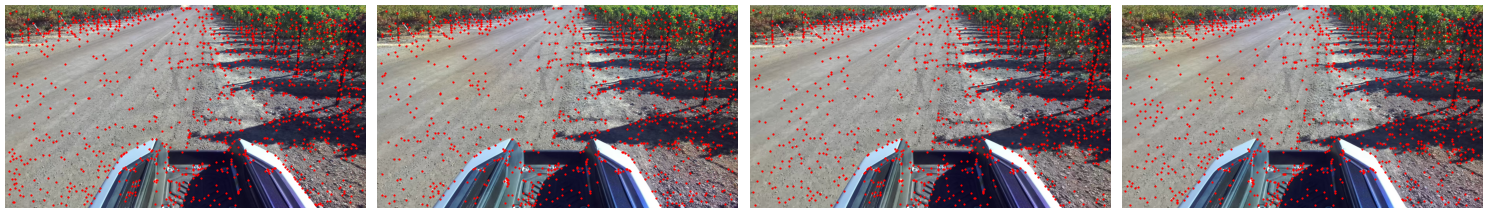

In [82]:
from hloc.utils.viz import plot_keypoints, save_plot
from hloc.utils.io import get_keypoints
import matplotlib.pyplot as plt
import numpy as np
import os

ref_trim_ = references[:4]
plot_images([read_image(images / r) for r in ref_trim_], dpi=50, figsize=4.2)

kps_list_ = [] 
for r in ref_trim_:
    kps = get_keypoints(features_path_, r)
    print(type(kps))
    kps_list_.append(kps)
    
plot_keypoints(kps_list_, colors = "red",  ps = 10)

current_path_ = os.getcwd()

print("current_path: ", current_path_)

print(type(current_path_))

final_path = current_path_ + "/kps.png"


save_plot(final_path)


In [83]:
import collections.abc as collections
isinstance(references, collections.Iterable)

True

In [84]:
pairs_from_exhaustive.stereo_main(sfm_pairs, image_list=references)

[2024/03/20 01:48:39 hloc INFO] Found 310 pairs.


In [85]:
#print("features: ", features)
#print("matches: ", matches)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

[2024/03/20 01:48:39 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


  0%|          | 0/310 [00:00<?, ?it/s]

[2024/03/20 01:48:56 hloc INFO] Finished exporting matches.


In [86]:
match_names = list_h5_names(matches)
for name in match_names: 
    if "right-52.jpg" in name: 
        print (name)

features: ../pixsfm_outputs/features.h5
kp1.shape: (1237, 2)
m.shape: (871, 2)


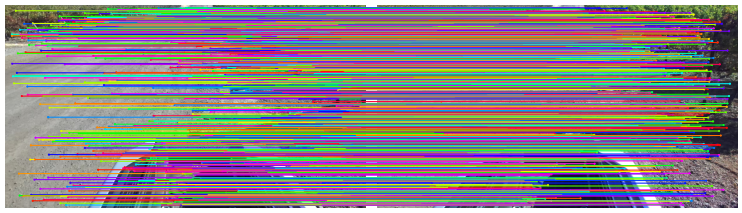

In [87]:
''' script to plot matches between two frames'''
from hloc.utils.viz import plot_matches
from hloc.utils.io import get_matches, get_keypoints
#img1 = images.joinpath(references[0])
#img2 = images.joinpath(references[1])

#print(f"img1 : {img1.as_posix()} img_2: {img2.as_posix()}")

print(f"features: {features}")
kp1 = get_keypoints(features, references[0])
kp2 = get_keypoints(features, references[1])
print(f"kp1.shape: {kp1.shape}")

m, _ = get_matches(matches, references[0], references[1])
print(f"m.shape: {m.shape}")

m1 = np.array([kp1[i] for i in m[:,0]])
m2 = np.array([kp2[i] for i in m[:, 1]])

#print(m1[:10])

plot_images([read_image(images / r) for r in references[:2]], dpi=50, figsize=4.2)
#plot_matches(kp1.transpose, kp2.transpose)
#plot_matches(kp1.transpose, kp2.transpose)
plot_matches(m1, m2)
#plot_matches(m[:,0], m[:,1])
#print(m[:10])
#kp1 = 
#matches, scores = 

Now we run the reconstruction with and without the featuremetric refinement. For this dataset, when computing the dense features, we resize the images such that they are not larger than 1024 pixels.

In [88]:
fx = 1093.2768
fy = 1093.2768
cx = 964.989
cy = 569.276
opencv_camera_params =','.join(map(str, (fx, fy, cx, cy, 0, 0, 0, 0)))

In [89]:
#sfm = PixSfM({"dense_features": {"max_edge": 1024}})


#conf1 = {"dense_features": {"max_edge": 1024}}

conf2 = {
    "BA": {"optimizer": {"refine_focal_length": False,"refine_extra_params": False, "refine_extrinsics": False}},
    "dense_features": {"max_edge":1024}
}

sfm = PixSfM(conf=conf2)



[2024/03/20 01:48:58 pixsfm.features.models.s2dnet INFO] Loading S2DNet checkpoint at /home/skumar/pixel-perfect-sfm/pixsfm/features/models/checkpoints/s2dnet_weights.pth.
[2024/03/20 01:48:58 pixsfm INFO] Loaded dense extractor with configuration:
{'cache_format': 'chunked',
 'device': 'auto',
 'dtype': 'half',
 'fast_image_load': False,
 'l2_normalize': True,
 'load_cache_on_init': False,
 'max_edge': 1024,
 'model': {'name': 's2dnet'},
 'overwrite_cache': False,
 'patch_size': 16,
 'pyr_scales': [1.0],
 'resize': 'LANCZOS',
 'sparse': True,
 'use_cache': False}


In [90]:
'''CASE 2 => INITIAL K IS PROVIDED + K IS LOCKED '''

image_options = dict(camera_model='OPENCV', 
                     camera_params=opencv_camera_params
                    )

mapper_options_one = dict(ba_refine_focal_length=False, 
                      ba_refine_extra_params=False,
                     ba_refine_principal_point=False)

mapper_options_two = dict(ba_refine_focal_length=False, 
                      ba_refine_extra_params=False,
                     ba_refine_principal_point=False)

hloc_args_not_locked = dict(image_list=references,
                image_options=image_options,
                camera_mode="PER_FOLDER",
                mapper_options=mapper_options_two)

#hloc_args_not_locked = dict(image_list=references)

K_locked, sfm_outputs_not_locked = sfm.reconstruction(ref_dir_locked, images, sfm_pairs, features, matches, **hloc_args_not_locked)


[2024/03/20 01:48:59 pixsfm INFO] Building matching graph...
[2024/03/20 01:48:59 pixsfm INFO] Extracting dense features...


  0%|          | 0/80 [00:00<?, ?it/s]

[2024/03/20 01:49:09 pixsfm INFO] Computing tracks...
[2024/03/20 01:49:09 pixsfm INFO] # graph nodes: 89118
[2024/03/20 01:49:09 pixsfm INFO] # graph edges: 257559
[2024/03/20 01:49:09 pixsfm INFO] # tracks: 7148
[2024/03/20 01:49:09 pixsfm INFO] Start feature-metric keypoint adjustment.


[2024/03/20 01:49:09 pixsfm WARNING] 429 / 1605 problems have more than 50 keypoints.
         Maximum keypoints in a problem: 80
100%[████████████████████] 89118/89118 [00:14, 6344.72it/s]


[2024/03/20 01:49:23 pixsfm INFO] KA Time: 14.0464s, cost change: 0.0209651 --> 0.0161015


[2024/03/20 01:49:23 hloc INFO] Creating an empty database...
[2024/03/20 01:49:23 hloc INFO] Importing images into the database...
[2024/03/20 01:49:24 hloc INFO] Importing features into the database...


  0%|          | 0/80 [00:00<?, ?it/s]

[2024/03/20 01:49:24 hloc INFO] Importing matches into the database...


  0%|          | 0/310 [00:00<?, ?it/s]

[2024/03/20 01:49:24 hloc INFO] Performing geometric verification of the matches...
[2024/03/20 01:49:25 hloc INFO] Running 3D reconstruction...
[2024/03/20 01:50:06 hloc INFO] Reconstructed 1 model(s).
[2024/03/20 01:50:06 hloc INFO] Largest model is #0 with 80 images.
[2024/03/20 01:50:06 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 80
	num_cameras = 2
	num_points3D = 7994
	num_observations = 51803
	mean_track_length = 6.48024
	mean_observations_per_image = 647.538
	mean_reprojection_error = 0.504213
	num_input_images = 80


[2024/03/20 01:50:06 pixsfm INFO] Extracting references.


100%[████████████████████] 7994/7994 [00:00, 18853.7it/s]


[2024/03/20 01:50:06 pixsfm INFO] Reference Extraction Time: 0.428421s
[2024/03/20 01:50:06 pixsfm INFO] Start feature-reference bundle adjustment.


100%[████████████████████] 101/101 [00:14, 7.15550it/s]


[2024/03/20 01:50:20 pixsfm INFO] BA Time: 14.1198s, cost change: 0.0179565 --> 0.0176464


In [91]:
print("Sparse reconstruction finished!")

Sparse reconstruction finished!


In [94]:
sys.path.append(os.path.expandvars('$HOME/colmap/scripts/python'))
from read_write_model import read_images_binary 
sparse_images = ref_dir_locked / "images.bin"
img_dict = read_images_binary(sparse_images)
print(img_dict)

{80: Image(id=80, qvec=array([ 0.99809424, -0.04884372, -0.01330885,  0.03528533]), tvec=array([-0.03390421, -1.55459698,  2.85048248]), camera_id=2, name='right/frame_9_.jpg', xys=array([[ 700.09655762,   17.92634201],
       [ 811.02191162,   15.22624588],
       [ 933.3168335 ,   15.02946568],
       ...,
       [ 724.07519531, 1064.23291016],
       [ 820.02929688, 1064.60888672],
       [1022.60162354, 1064.93676758]]), point3D_ids=array([  -1,   -1,   -1, ..., 7903, 7904,   -1])), 79: Image(id=79, qvec=array([ 0.99809307, -0.04923859, -0.01215439,  0.03518602]), tvec=array([-0.03604339, -1.69670629,  3.13309581]), camera_id=2, name='right/frame_8_.jpg', xys=array([[ 511.2979126 ,   16.44180107],
       [ 935.12414551,   16.46754837],
       [ 965.56726074,   15.08907318],
       ...,
       [ 818.65649414, 1065.0916748 ],
       [1020.75524902, 1065.13696289],
       [1117.7175293 , 1063.14733887]]), point3D_ids=array([  -1,   -1,   -1, ..., 8137, 8177, 8139])), 78: Image(id=78, 

In [95]:
sorted_keys = sorted(img_dict.keys())

for key in sorted_keys: 
    print(f"{key} => {img_dict[key].name}")

# for k,v in img_dict.items(): 
#     print(f"{k} ==> {v.name}")

1 => left/frame_0_.jpg
2 => left/frame_10_.jpg
3 => left/frame_11_.jpg
4 => left/frame_12_.jpg
5 => left/frame_13_.jpg
6 => left/frame_14_.jpg
7 => left/frame_15_.jpg
8 => left/frame_16_.jpg
9 => left/frame_17_.jpg
10 => left/frame_18_.jpg
11 => left/frame_19_.jpg
12 => left/frame_1_.jpg
13 => left/frame_20_.jpg
14 => left/frame_21_.jpg
15 => left/frame_22_.jpg
16 => left/frame_23_.jpg
17 => left/frame_24_.jpg
18 => left/frame_25_.jpg
19 => left/frame_26_.jpg
20 => left/frame_27_.jpg
21 => left/frame_28_.jpg
22 => left/frame_29_.jpg
23 => left/frame_2_.jpg
24 => left/frame_30_.jpg
25 => left/frame_31_.jpg
26 => left/frame_32_.jpg
27 => left/frame_33_.jpg
28 => left/frame_34_.jpg
29 => left/frame_35_.jpg
30 => left/frame_36_.jpg
31 => left/frame_37_.jpg
32 => left/frame_38_.jpg
33 => left/frame_39_.jpg
34 => left/frame_3_.jpg
35 => left/frame_4_.jpg
36 => left/frame_5_.jpg
37 => left/frame_6_.jpg
38 => left/frame_7_.jpg
39 => left/frame_8_.jpg
40 => left/frame_9_.jpg
41 => right/frame_0